# Создайте модель машинного обучения для прогнозирования набора данных по варианту

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Academic/ML/Lab10 - RNN/monthly-beer-production-in-austr.csv")

In [4]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [6]:
features = df['Monthly beer production']
features.index = df['Month']
features.head()

Month
1956-01    93.2
1956-02    96.0
1956-03    95.2
1956-04    77.1
1956-05    70.9
Name: Monthly beer production, dtype: float64

array([<Axes: xlabel='Month'>], dtype=object)

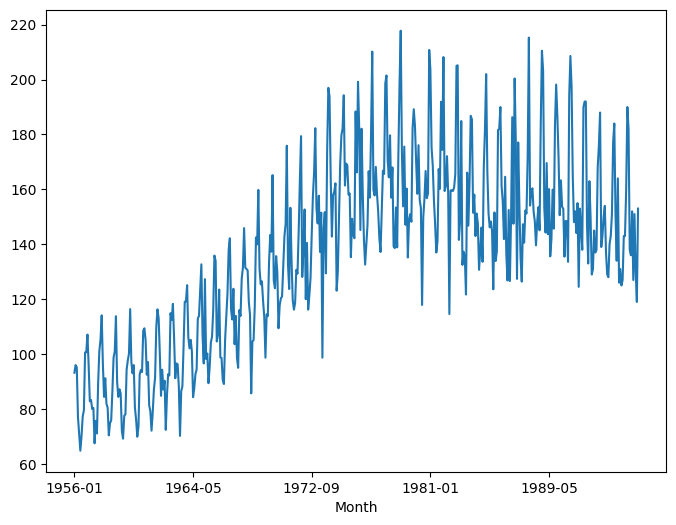

In [7]:
features.plot(subplots=True)

In [8]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000
TRAIN_SPLIT = 300
EVALUATION_INTERVAL = 100
EPOCHS = 10

In [9]:
uni_data = features.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [10]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Потери на этапе обучения')
  plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
  plt.title(title)
  plt.legend()

  plt.show()

In [11]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Изменение размера данных с (history_size,) на (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [12]:
def create_time_steps(length):
  return list(range(-length, 0))

In [13]:
tf.random.set_seed(13)

In [14]:
univariate_future_target = 0
univariate_past_history = 12
STEP = 1

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [15]:
print ('Временной интервал для наблюдений')
print (x_train_uni[0])
print ('\n Целевое производство для прогнозирования')
print (y_train_uni[0])

Временной интервал для наблюдений
[[-0.92954161]
 [-0.84707713]
 [-0.87063841]
 [-1.40371239]
 [-1.58631232]
 [-1.76596708]
 [-1.6098736 ]
 [-1.39782207]
 [-1.33302855]
 [-0.71159977]
 [-0.70865461]
 [-0.52016436]]

 Целевое производство для прогнозирования
-0.8500222915681321


In [16]:
def show_plot(plot_data, delta, title):
  labels = ['История', 'Истинное будущее значение', 'Прогноз модели']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Временной интервал')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

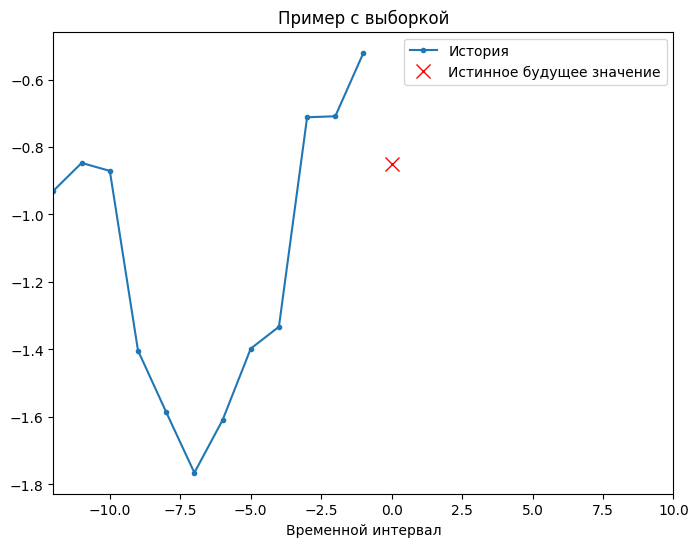

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Пример с выборкой')

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [44]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [45]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

2/2 [==============================] - 0s 7ms/step
(64, 1)


In [46]:
EVALUATION_INTERVAL = 200
EPOCHS = 50

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/50
200/200 [==============================] - 4s 9ms/step - loss: 0.5083 - val_loss: 0.4921
Epoch 2/50
200/200 [==============================] - 1s 7ms/step - loss: 0.4046 - val_loss: 0.4709
Epoch 3/50
200/200 [==============================] - 2s 10ms/step - loss: 0.3431 - val_loss: 0.3902
Epoch 4/50
200/200 [==============================] - 2s 12ms/step - loss: 0.3039 - val_loss: 0.3447
Epoch 5/50
200/200 [==============================] - 2s 10ms/step - loss: 0.2913 - val_loss: 0.3659
Epoch 6/50
200/200 [==============================] - 1s 7ms/step - loss: 0.2917 - val_loss: 0.3862
Epoch 7/50
200/200 [==============================] - 1s 7ms/step - loss: 0.2867 - val_loss: 0.3270
Epoch 8/50
200/200 [==============================] - 1s 7ms/step - loss: 0.2851 - val_loss: 0.3244
Epoch 9/50
200/200 [==============================] - 1s 7ms/step - loss: 0.2847 - val_loss: 0.3091
Epoch 10/50
200/200 [==============================] - 1s 7ms/step - loss: 0.2846 - val_loss: 0.3

In [47]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Потери на этапе обучения')
  plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
  plt.title(title)
  plt.legend()

  plt.show()

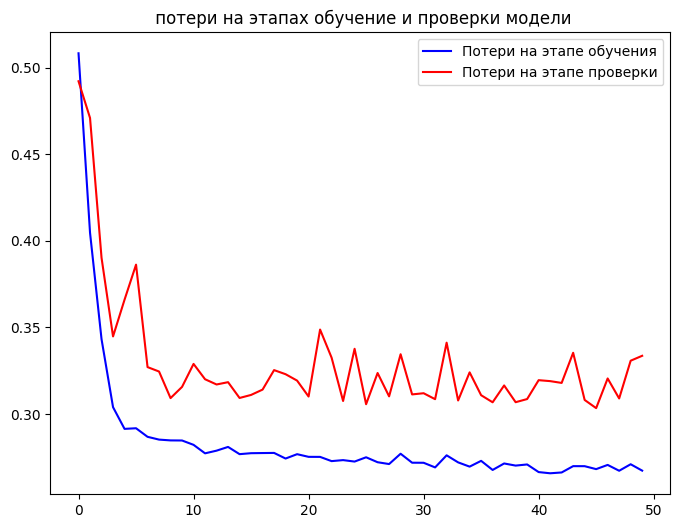

In [48]:
plot_train_history(history, ' потери на этапах обучение и проверки модели')

2/2 [==============================] - 0s 6ms/step


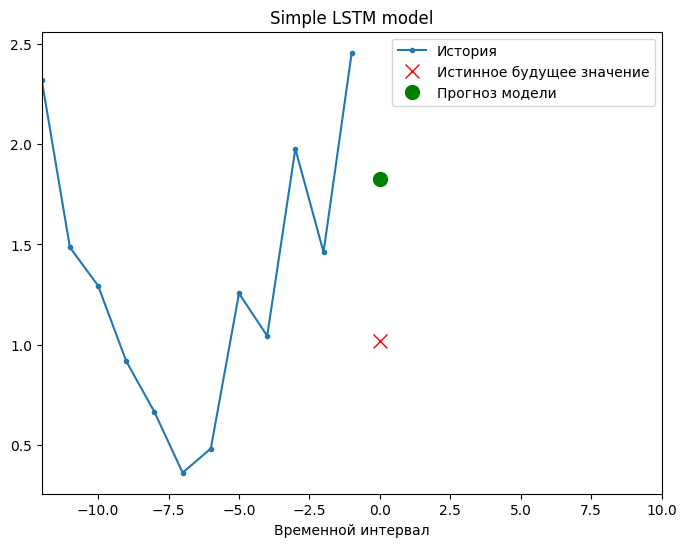

2/2 [==============================] - 0s 7ms/step


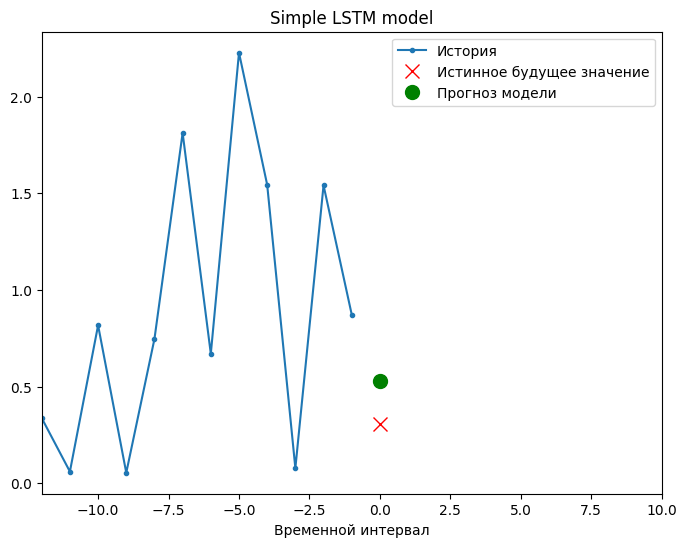

2/2 [==============================] - 0s 8ms/step


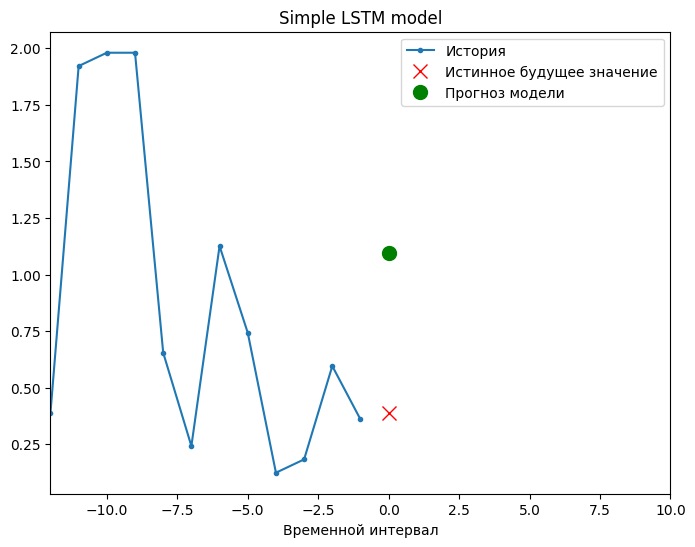

In [52]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()